## Library

In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 40000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor')  # Cache generated in "Anchors" notebook
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 23.5,
 5: 25.1,
 10: 25.9,
 20: 26.8,
 30: 27.8,
 40: 29.0,
 50: 30.8,
 60: 32.7,
 70: 34.8,
 80: 37.4,
 90: 41.1,
 95: 43.9,
 99: 50.1}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.1,
 5: 7.4,
 10: 7.5,
 20: 7.7,
 30: 7.9,
 40: 8.0,
 50: 8.1,
 60: 8.3,
 70: 8.4,
 80: 8.7,
 90: 9.1,
 95: 9.5,
 99: 10.3}

## Chance of nonscaling delay ##


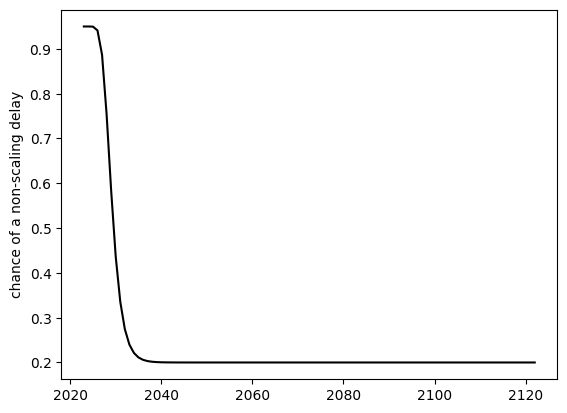

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 94%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 75%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 44%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2033

In [5]:
# PROBABILITY OF A NONSCALING DELAY
# Cache defined in "(3B) Nonscaling Delay Curve"
# Set p_delay_ = 0 if you do not want a nonscaling delay. Otherwise set this to the array of your choice.
# Note that the amount of years of delay is defined separately
with open('caches/nonscaling_delay_array.npy', 'rb') as f:
    p_delay_ = np.load(f)

print('## Chance of nonscaling delay ##')
plt.plot(years, p_delay_, color='black')
plt.ylabel('chance of a non-scaling delay')
plt.show()

for y in years[:10] + years[10::10]:
    outstr = 'Year: {} - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: {}%'
    print(outstr.format(y, int(round(p_delay_[y - CURRENT_YEAR] * 100))))


In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    return ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': 5,
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(2.5, 3),       # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 24),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             'p_nonscaling_delay': p_delay_,
             'nonscaling_delay': sq.mixture([sq.lognorm(3, 10), sq.lognorm(10, 40)], weights=0.9)}

print('Loaded')


Loaded


## Run Wildeford timelines model

## RUN TIMELINES MODEL ##
Generating Bayes net with 6 cores...


40020it [13:16, 50.27it/s]                                                                            


Shuffling data...
Waiting for other cores...
.....Collecting data...


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1144.11it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2028',
 '10%: 2029',
 '15%: 2030',
 '20%: 2031',
 '25%: 2032',
 '35%: 2034',
 '50%: 2041',
 '60%: 2050',
 '75%: 2099',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 5 years from now',
 '10%: 6 years from now',
 '15%: 7 years from now',
 '20%: 8 years from now',
 '25%: 9 years from now',
 '35%: 11 years from now',
 '50%: 18 years from now',
 '60%: 27 years from now',
 '75%: 76 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.7%
2024-2027: 1.2%
2028-2029: 12.0%
2030-2034: 21.8%
2035-2039: 11.6%
2040-2049: 12.4%
2050-2059: 8.6%
2060-2069: 3.7%
2070-2079: 1.5%
2080-2089: 0.8%
2090-2099: 0.6%
2100-2109: 0.5%
2110-2119: 0.4%
>2120: 24.1%
-
## TAI

By EOY 2024: 0.8%
By EOY 2025: 1.1%
By EOY 2027: 4.7% (within 5 yrs)
By EOY 2030: 19.2% (Ajeya 2022: 15%)
By EOY 2032: 28.7% (within 10yrs)
By EOY 2036: 41.4% (Holden 2021 benchmark - 10%-50%, Holden 2021: 10%; Ajeya 2022: 35%)
By EOY 2040: 48.9% (Ajeya 2022: 50%)
By EOY 2042: 51.8% (FTX: 20%, 10%-45%)
By EOY 2047: 57.6% (within 25yrs)
By EOY 2050: 60.9% (Ajeya 2020: 50%, Ajeya 2022: 60%)
By EOY 2060: 68.9% (Holden 2021 benchmark - 25%-75%, Holden 2021: 50%)
By EOY 2070: 72.4% (Carlsmith: 50%)
By EOY 2072: 72.7% (within 50yrs)
By EOY 2078: 73.5% (within my expected lifetime)
By EOY 2099: 75.0% (FTX: 60%, >30%)
By EOY 2100: 75.1% (Holden 2021 benchmark - 33%-90%, Holden 2021: 66%)
By EOY 2122: 76.0% (within 100yrs)
-
-


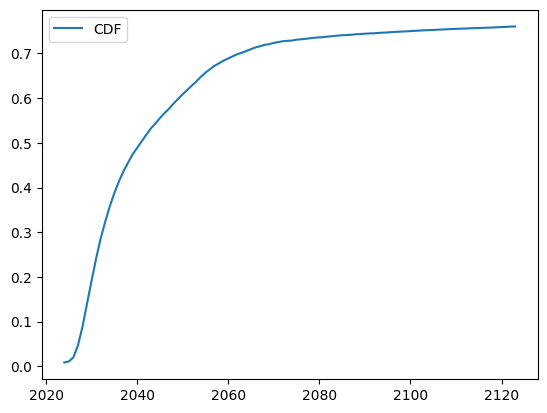

<string>:111: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:112: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

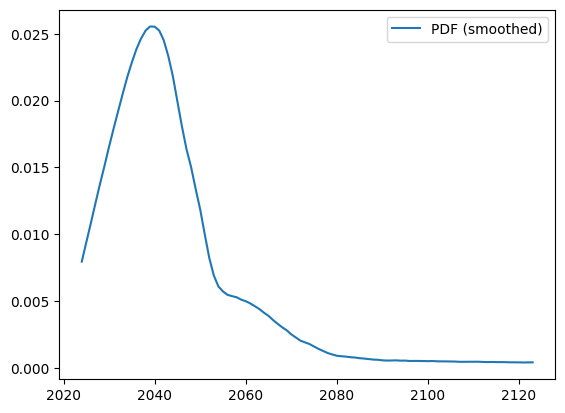

-
-
## TAI FLOP SIZE ##
{1: 23.2,
 5: 24.8,
 10: 25.7,
 20: 26.8,
 30: 28.0,
 40: 29.0,
 50: 30.7,
 60: 32.8,
 70: 34.7,
 80: 37.4,
 90: 41.4,
 95: 44.3,
 99: 49.6}


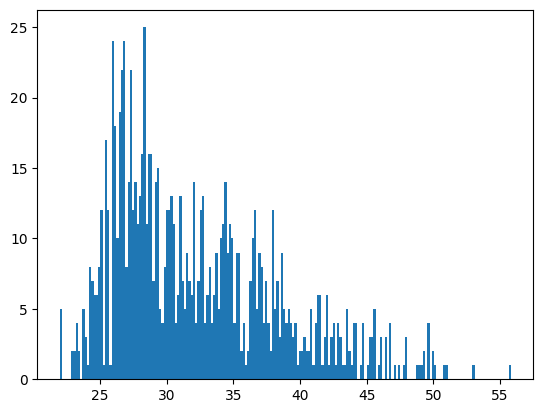

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION: 5 ##
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.1,
 5: 3.0,
 10: 2.9,
 20: 2.9,
 30: 2.8,
 40: 2.8,
 50: 2.8,
 60: 2.7,
 70: 2.7,
 80: 2.6,
 90: 2.5,
 95: 2.5,
 99: 2.4}


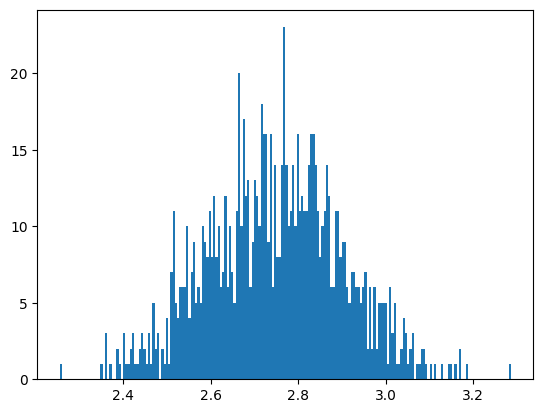

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.3,
 5: 21.0,
 10: 21.3,
 20: 21.7,
 30: 22.0,
 40: 22.2,
 50: 22.5,
 60: 22.7,
 70: 23.0,
 80: 23.3,
 90: 23.6,
 95: 24.0,
 99: 24.7}


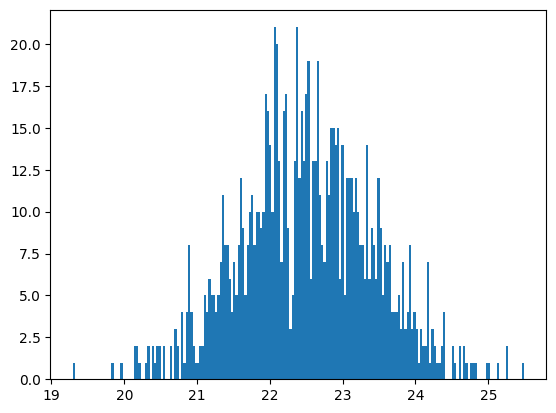

-
-
## INITIAL PAY ##
{1: 7.1,
 5: 7.4,
 10: 7.5,
 20: 7.7,
 30: 7.9,
 40: 8.0,
 50: 8.1,
 60: 8.3,
 70: 8.4,
 80: 8.7,
 90: 9.1,
 95: 9.4,
 99: 10.4}


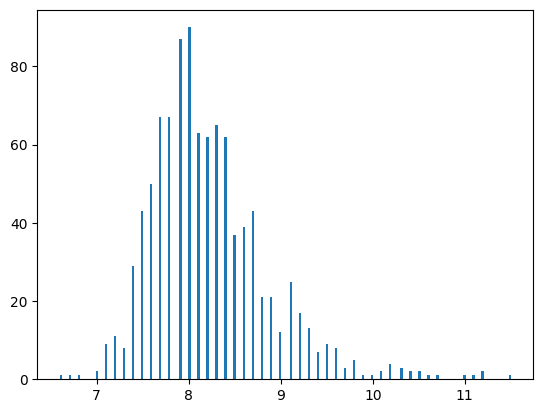

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}


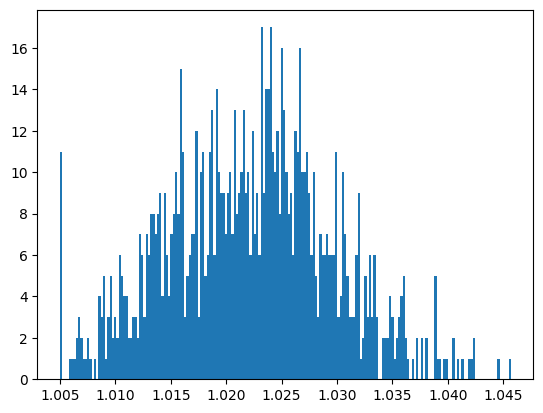

-
-
## MAX GDP FRAC ##
{1: 0.0,
 5: 1e-05,
 10: 6e-05,
 20: 0.00015,
 30: 0.00021,
 40: 0.00029,
 50: 0.00038,
 60: 0.0005,
 70: 0.00069,
 80: 0.001,
 90: 0.00191,
 95: 0.00391,
 99: 0.0103}


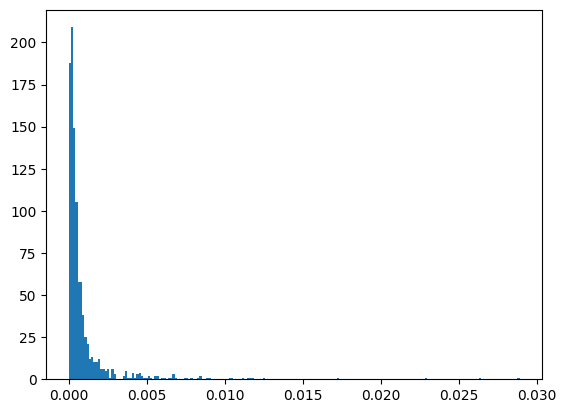

-
-
## NONSCALING DELAY ##
{1: 3,
 5: 3,
 10: 3,
 20: 4,
 30: 5,
 40: 5,
 50: 6,
 60: 6,
 70: 7,
 80: 8,
 90: 12,
 95: 21,
 99: 33}


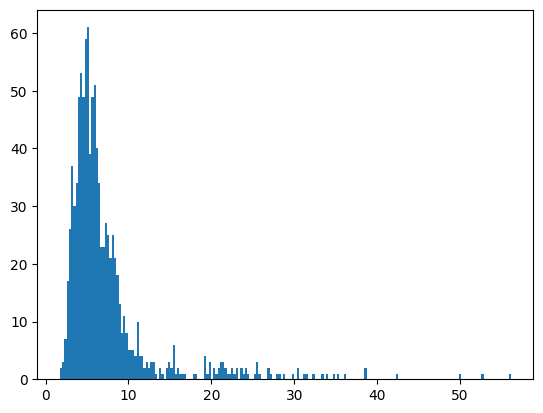

-
-
## SPEND DOUBLING TIME ##
{1: 5.1,
 5: 4.5,
 10: 4.2,
 20: 3.8,
 30: 3.5,
 40: 3.3,
 50: 3.0,
 60: 2.8,
 70: 2.6,
 80: 2.2,
 90: 1.9,
 95: 1.4,
 99: 1.0}


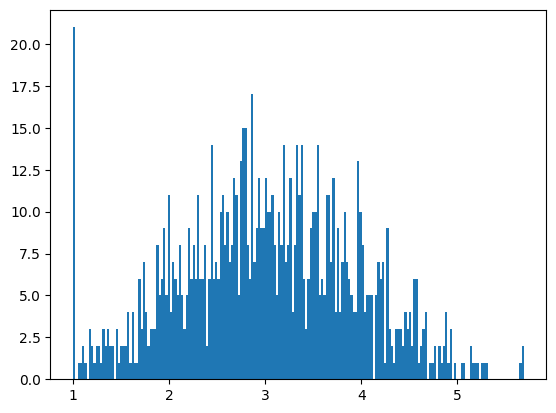

-
-
-
-
## GDP Over Time ##


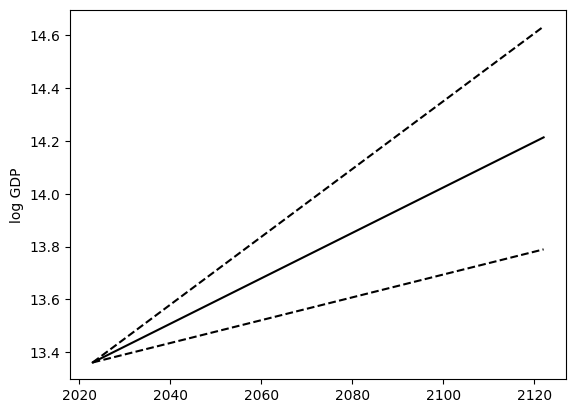

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

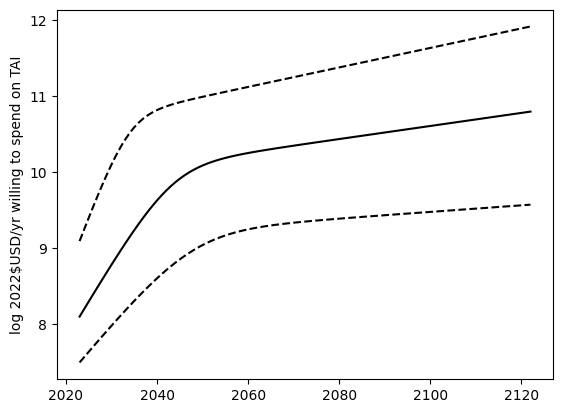

Year: 2023 - willingness log 2022$USD per year 8.1 (~124 million) 90% CI 7.5 (~31 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.2 (~156 million) 90% CI 7.6 (~36 million) - 9.2 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.3 (~196 million) 90% CI 7.6 (~43 million) - 9.4 (~2 billion)
Year: 2026 - willingness log 2022$USD per year 8.4 (~245 million) 90% CI 7.7 (~50 million) - 9.5 (~3 billion)
Year: 2027 - willingness log 2022$USD per year 8.5 (~307 million) 90% CI 7.8 (~59 million) - 9.7 (~5 billion)
Year: 2028 - willingness log 2022$USD per year 8.6 (~384 million) 90% CI 7.8 (~69 million) - 9.8 (~7 billion)
Year: 2029 - willingness log 2022$USD per year 8.7 (~479 million) 90% CI 7.9 (~80 million) - 10.0 (~9 billion)
Year: 2030 - willingness log 2022$USD per year 8.8 (~597 million) 90% CI 8.0 (~94 million) - 10.1 (~12 billion)
Year: 2031 - willingness log 2022$USD per year 8.9 (~741 million) 90% CI 8.0 (~110 million) - 10.2 (~16 billion)
Year

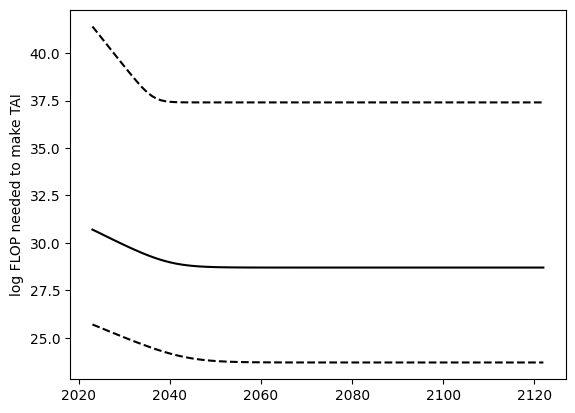

Year: 2023 - log FLOP needed for TAI 30.7 (~5 nonillion) 90% CI 25.7 (~50 septillion) - 41.4 (~251 million decillion)
Year: 2024 - log FLOP needed for TAI 30.6 (~4 nonillion) 90% CI 25.6 (~40 septillion) - 41.1 (~126 million decillion)
Year: 2025 - log FLOP needed for TAI 30.5 (~3 nonillion) 90% CI 25.5 (~32 septillion) - 40.8 (~63 million decillion)
Year: 2026 - log FLOP needed for TAI 30.3 (~2 nonillion) 90% CI 25.4 (~26 septillion) - 40.5 (~31 million decillion)
Year: 2027 - log FLOP needed for TAI 30.2 (~2 nonillion) 90% CI 25.3 (~20 septillion) - 40.2 (~16 million decillion)
Year: 2028 - log FLOP needed for TAI 30.1 (~1 nonillion) 90% CI 25.2 (~16 septillion) - 39.9 (~8 million decillion)
Year: 2029 - log FLOP needed for TAI 30.0 (~1000 octillion) 90% CI 25.1 (~13 septillion) - 39.6 (~4 million decillion)
Year: 2030 - log FLOP needed for TAI 29.9 (~770 octillion) 90% CI 25.0 (~10 septillion) - 39.3 (~2 million decillion)
Year: 2031 - log FLOP needed for TAI 29.8 (~596 octillion) 9

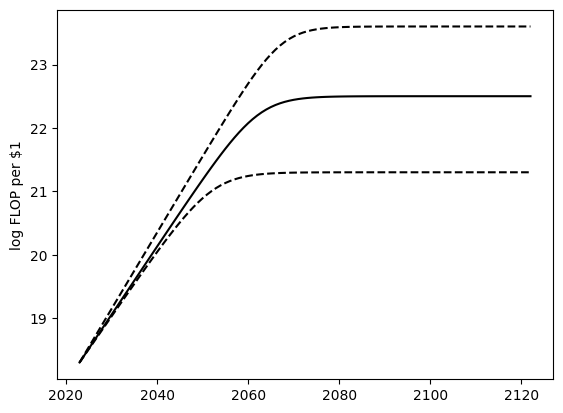

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~3 quintillion) - 18.4 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.5 (~3 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.6 (~4 quintillion) 90% CI 18.6 (~4 quintillion) - 18.7 (~5 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.7 (~5 quintillion) - 18.8 (~6 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.8 (~7 quintillion) 90% CI 18.8 (~7 quintillion) - 18.9 (~8 quintillion)
Year: 2029 - log FLOP per 2022$1USD 18.9 (~9 quintillion) 90% CI 18.9 (~8 quintillion) - 19.0 (~11 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~11 quintillion) 90% CI 19.0 (~11 quintillion) - 19.1 (~14 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.2 (~14 quintillion) 90% CI 19.1 (~13 quintillion) - 19.3 (~18 quintil

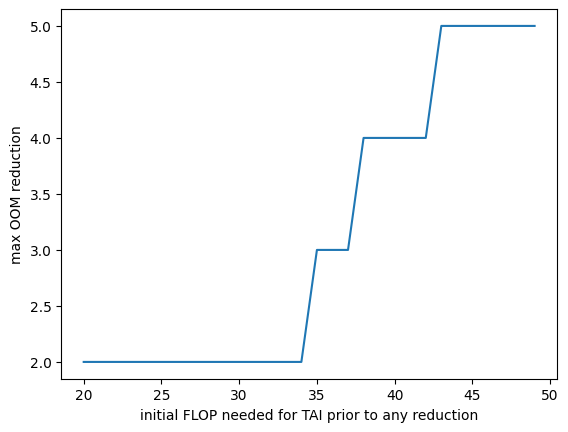

TAI log FLOP 20 -> 2.0 OOM reductions possible
TAI log FLOP 21 -> 2.0 OOM reductions possible
TAI log FLOP 22 -> 2.0 OOM reductions possible
TAI log FLOP 23 -> 2.0 OOM reductions possible
TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 

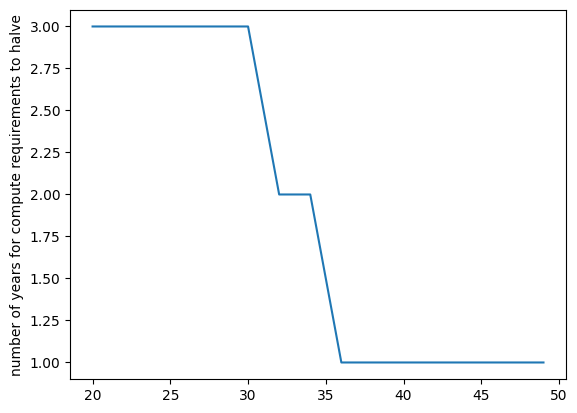

TAI log FLOP 20 -> algo doubling rate 3.0yrs
TAI log FLOP 21 -> algo doubling rate 3.0yrs
TAI log FLOP 22 -> algo doubling rate 3.0yrs
TAI log FLOP 23 -> algo doubling rate 3.0yrs
TAI log FLOP 24 -> algo doubling rate 3.0yrs
TAI log FLOP 25 -> algo doubling rate 3.0yrs
TAI log FLOP 26 -> algo doubling rate 3.0yrs
TAI log FLOP 27 -> algo doubling rate 3.0yrs
TAI log FLOP 28 -> algo doubling rate 3.0yrs
TAI log FLOP 29 -> algo doubling rate 3.0yrs
TAI log FLOP 30 -> algo doubling rate 3.0yrs
TAI log FLOP 31 -> algo doubling rate 2.5yrs
TAI log FLOP 32 -> algo doubling rate 2.0yrs
TAI log FLOP 33 -> algo doubling rate 2.0yrs
TAI log FLOP 34 -> algo doubling rate 2.0yrs
TAI log FLOP 35 -> algo doubling rate 1.5yrs
TAI log FLOP 36 -> algo doubling rate 1.0yrs
TAI log FLOP 37 -> algo doubling rate 1.0yrs
TAI log FLOP 38 -> algo doubling rate 1.0yrs
TAI log FLOP 39 -> algo doubling rate 1.0yrs
TAI log FLOP 40 -> algo doubling rate 1.0yrs
TAI log FLOP 41 -> algo doubling rate 1.0yrs
TAI log FL

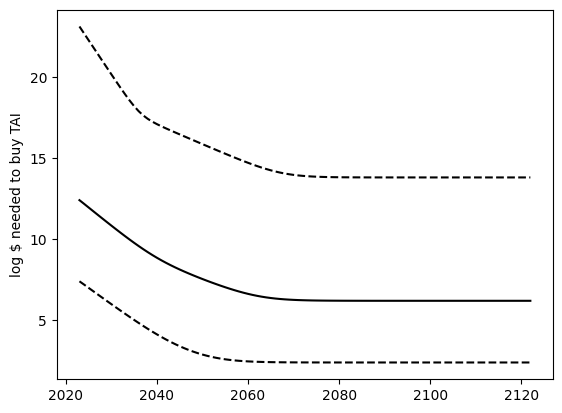

Year: 2023 - 12.4 log 2022$USD to buy TAI (~3 trillion) 90% CI 7.4 (~25 million) - 23.1 (~126 sextillion)
Year: 2024 - 12.2 log 2022$USD to buy TAI (~2 trillion) 90% CI 7.2 (~16 million) - 22.7 (~48 sextillion)
Year: 2025 - 12.0 log 2022$USD to buy TAI (~895 billion) 90% CI 7.0 (~10 million) - 22.3 (~18 sextillion)
Year: 2026 - 11.7 log 2022$USD to buy TAI (~532 billion) 90% CI 6.8 (~6 million) - 21.8 (~7 sextillion)
Year: 2027 - 11.5 log 2022$USD to buy TAI (~317 billion) 90% CI 6.6 (~4 million) - 21.4 (~3 sextillion)
Year: 2028 - 11.3 log 2022$USD to buy TAI (~189 billion) 90% CI 6.4 (~2 million) - 21.0 (~987 quintillion)
Year: 2029 - 11.1 log 2022$USD to buy TAI (~113 billion) 90% CI 6.2 (~2 million) - 20.6 (~375 quintillion)
Year: 2030 - 10.8 log 2022$USD to buy TAI (~68 billion) 90% CI 6.0 (~988 thousand) - 20.2 (~143 quintillion)
Year: 2031 - 10.6 log 2022$USD to buy TAI (~41 billion) 90% CI 5.8 (~626 thousand) - 19.7 (~55 quintillion)
Year: 2032 - 10.4 log 2022$USD to buy TAI (~

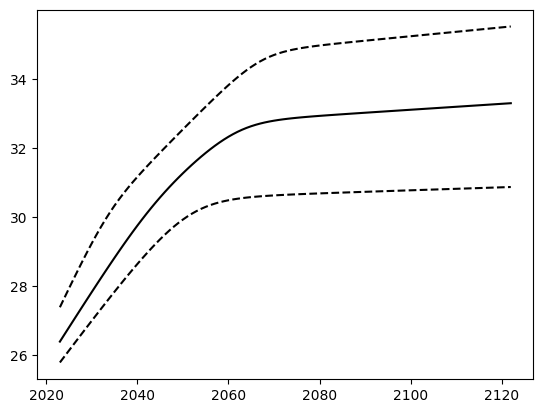

Year: 2023 - max log FLOP 26.4 (~248 septillion) 90% CI 25.8 (~62 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log FLOP 26.6 (~398 septillion) 90% CI 26.0 (~92 septillion) - 27.7 (~5 octillion)
Year: 2025 - max log FLOP 26.8 (~640 septillion) 90% CI 26.1 (~137 septillion) - 27.9 (~9 octillion)
Year: 2026 - max log FLOP 27.0 (~1 octillion) 90% CI 26.3 (~204 septillion) - 28.2 (~16 octillion)
Year: 2027 - max log FLOP 27.2 (~2 octillion) 90% CI 26.5 (~304 septillion) - 28.5 (~30 octillion)
Year: 2028 - max log FLOP 27.4 (~3 octillion) 90% CI 26.7 (~452 septillion) - 28.7 (~54 octillion)
Year: 2029 - max log FLOP 27.6 (~4 octillion) 90% CI 26.8 (~671 septillion) - 29.0 (~97 octillion)
Year: 2030 - max log FLOP 27.8 (~7 octillion) 90% CI 27.0 (~994 septillion) - 29.2 (~173 octillion)
Year: 2031 - max log FLOP 28.0 (~11 octillion) 90% CI 27.2 (~1 octillion) - 29.5 (~301 octillion)
Year: 2032 - max log FLOP 28.2 (~17 octillion) 90% CI 27.3 (~2 octillion) - 29.7 (~512 octillion)
Year: 2

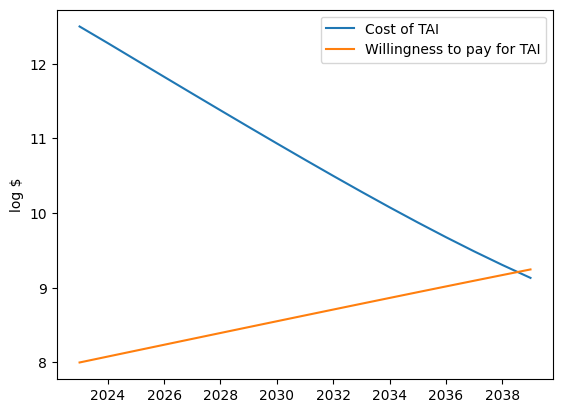

-
-
## SAMPLE RUN 2 ##
It takes 33.7 log FLOP (~5 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~33 sextillion) per 2022$USD.
We are willing to pay 8.0 log 2022$USD (~100 million) and this doubles every 2.4 years to a max of 0.001879% of GDP. GDP grows at a rate of 1.018x per year.
If a non-scaling delay happens, it will take an additional 9.8 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2023 - 26.3 max log FLOP (199 septillion) available - TAI takes 33.7 log FLOP (5 decillion) - log $ 15.4 to buy TAI (3 quadrillion) vs. willingness to pay log $ 8.0 (100 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (346 septillion) available - TAI takes 33.6 log FLOP (4 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to 

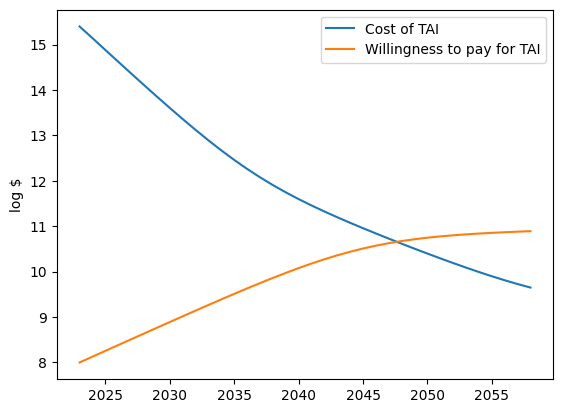

-
-
## SAMPLE RUN 3 ##
It takes 38.6 log FLOP (~398 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~38 sextillion) per 2022$USD.
We are willing to pay 7.9 log 2022$USD (~79 million) and this doubles every 4.1 years to a max of 0.000539% of GDP. GDP grows at a rate of 1.027x per year.
If a non-scaling delay happens, it will take an additional 4.4 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2023 - 26.2 max log FLOP (157 septillion) available - TAI takes 38.6 log FLOP (398 thousand decillion) - log $ 20.3 to buy TAI (200 quintillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (233 septillion) available - TAI takes 38.3 log FLOP (199 thousand decillion) - log $ 19.9 to buy TAI (80 

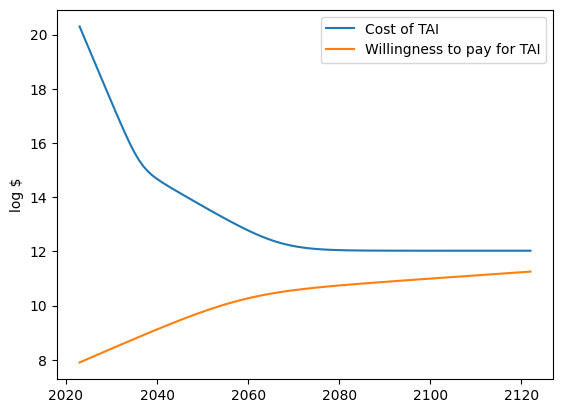

In [7]:
run_timelines_model(variables, cores=6, runs=RUNS, dump_cache_file='caches/tai_years')